In [ ]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
from scipy.stats import linregress

In [ ]:
# device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'You are happily using {device}')

You are happily using cuda


In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainloader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=2,
                                          pin_memory=True)

testloader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform),
                                         batch_size=1024,
                                         shuffle=False,
                                         num_workers=2,
                                         pin_memory=True)

In [ ]:
# Network used
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32 * 28 * 28, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Set the seeds
def seeding(seed = 1234):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True


In [ ]:
# Define the models used
MODELS = ["AGD", "GD", 'adaptive_support_FISTA', 'adaptive_mu_FISTA', "FISTA", "ISTA"]
models = {name: CNN().to(device).to(torch.float32) for name in MODELS}

# Loss function
criterion = nn.CrossEntropyLoss()
seeding()

# Params to go around
lambda_ = 0.001
lr = 0.01
max_iters = 10
tol = 1e-5
SUPPORT = 1e-3
SPARSITY_THRESHOLD = 1e-5

In [ ]:
# Proximal Operator
def prox_l1(w, alpha):
    return torch.sign(w) * torch.relu(torch.abs(w) - alpha)

# Training function
def train_optimizer(model, method):

  print('-'*20)
  print(f'Performing calculations for {method}')

  # Xavies initialize
  for param in model.parameters():
    if param.dim() >= 2:
      # Only apply to weight matrices, not biases
      torch.nn.init.xavier_uniform_(param)

  # Params for adaptive_FISTA
  if method == 'adaptive_mu_FISTA':
    L = 10
    alpha_k = 1 / L
    mu = 0.01
    k_iter = 1
    z_k = [p.clone() for p in model.parameters()]

  if method == 'adaptive_support_FISTA':
    L = 10
    alpha_k = 1 / L
    mu = 0.01
    k_iter = 1
    z_k = [p.clone() for p in model.parameters()]
    c = 0.1

  # Params to store
  optimizer, w_old = None, None
  losses, sparsities = [], []
  t = 1

  for epoch in range(max_iters):
    total_loss, total_sparsity = 0, 0
    start_time = time.time()

    for images, labels in trainloader:
      images, labels = images.to(device, dtype=torch.float32, non_blocking=True), labels.to(device)

      optimizer.zero_grad() if optimizer else None
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()


      with torch.no_grad():

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(
            (p for p in model.parameters() if p.dim() >= 2),
            max_norm = 2.0 if method != 'AGD' else 1.0
        )

        sparsity_accumulator = 0  # Accumulate sparsity over all params

        for i, param in enumerate(model.parameters()):

            if param.dim() >= 2:  # Only apply to weights, not biases

              if method == "ISTA":
                  param -= lr * param.grad
                  param.copy_(prox_l1(param, lr * lambda_))

              elif method == "FISTA":
                  z = param.clone()
                  param -= lr * param.grad
                  param.copy_(prox_l1(param, lr * lambda_))
                  t_new = (1 + (1 + 4 * t**2) ** 0.5) / 2
                  z += ((t - 1) / t_new) * (param - z)
                  t = t_new

              elif method == "adaptive_mu_FISTA":

                # Save previous iterate for momentum
                z_prev = z_k[i].clone()

                # Adaptive Step-Size Update
                alpha_k = (1 / L) + k_iter * mu  # Implement Silva & Rodriguez (2019)
                #print(alpha_k)
                alpha_k = min((1 / L) * alpha_k, 1 / L)  # Clipping to prevent divergence

                # Proximal Gradient Step
                param -= alpha_k * param.grad
                param.copy_(prox_l1(param, alpha_k * lambda_))

                # Momentum Update
                t_new = (1 + (1 + 4 * t**2) ** 0.5) / 2
                z_k[i] = param + ((t - 1) / t_new) * (param - z_prev)
                t = t_new

                # Increase iteration counter
                k_iter += 1

              elif method == 'adaptive_support_FISTA':
                # Save previous iterate for momentum
                z_prev = z_k[i].clone()

                # Compute support-based step-size
                s_k = (torch.abs(param) > SUPPORT).float()  # Support of current solution
                g_k = param.grad  # Gradient
                conv_input = s_k * g_k

                # Phi function basically
                if conv_input.dim() == 4:  # If it's a convolutional layer
                  if conv_input.shape[1] != 1:  # Ensure correct number of channels
                    conv_input = conv_input.mean(dim=1, keepdim=True)  # Reduce to 1 channel
                  conv_output = model.conv1(conv_input)  # Apply CNN transformation
                  conv_output = torch.relu(model.bn1(conv_output))
                  conv_output = torch.relu(model.bn2(model.conv2(conv_output)))
                elif conv_input.dim() == 2:  # If it's a fully connected layer
                    conv_input = conv_input.flatten(start_dim=1)  # Ensure correct shape
                    conv_output = model.fc(conv_input)  # Pass through linear layer

                numerator = torch.norm(conv_input) ** 2
                denominator = torch.norm(conv_output) ** 2  # Phi is the linear operator
                alpha_k = c * (numerator / (denominator + 1e-8))

                # Clip step-size to prevent divergence
                alpha_k = min(alpha_k, 1 / L)

                # Proximal Gradient Step
                param -= alpha_k * param.grad
                param.copy_(prox_l1(param, alpha_k * lambda_))

                # Momentum Update
                t_new = (1 + (1 + 4 * t**2) ** 0.5) / 2
                z_k[i] = param + ((t - 1) / t_new) * (param - z_prev)
                t = t_new

                # Increase iteration counter
                k_iter += 1

              elif method == "GD":
                  param -= lr * (param.grad + lambda_ * param)

              elif method == "AGD":
                  if w_old is None:
                      w_old = [p.clone().detach() for p in model.parameters()]

                  agd_learning_rate = lr / 100
                  for i, param in enumerate(model.parameters()):
                      temp = param.clone()
                      param -= agd_learning_rate * (param.grad + lambda_ * param)
                      param += 0.9 * (param - w_old[i])
                      w_old[i] = temp.clone().detach()

      total_loss += loss.item()

    avg_loss = total_loss / len(trainloader)
    losses.append(avg_loss)

    print(f"{method} - Epoch {epoch + 1}: Loss={avg_loss:.4f}, Time={time.time()-start_time:.2f}s")

    if epoch > 1 and np.abs(losses[-1] - losses[-2]) < tol:
        break

  return losses, epoch + 1


In [ ]:
# Train them models
results = {}
for method in models:
  results[method] = train_optimizer(
      models[method], method
  )

--------------------
Performing calculations for AGD
AGD - Epoch 1: Loss=0.7775, Time=11.93s
AGD - Epoch 2: Loss=0.2854, Time=11.98s
AGD - Epoch 3: Loss=0.2296, Time=11.77s
AGD - Epoch 4: Loss=0.1960, Time=11.86s
AGD - Epoch 5: Loss=0.1729, Time=11.95s
AGD - Epoch 6: Loss=0.1576, Time=13.10s
AGD - Epoch 7: Loss=0.1469, Time=11.97s
AGD - Epoch 8: Loss=0.1366, Time=11.51s
AGD - Epoch 9: Loss=0.1307, Time=11.43s
AGD - Epoch 10: Loss=0.1211, Time=11.64s
--------------------
Performing calculations for GD
GD - Epoch 1: Loss=0.3584, Time=11.02s
GD - Epoch 2: Loss=0.0960, Time=11.10s
GD - Epoch 3: Loss=0.0641, Time=11.15s
GD - Epoch 4: Loss=0.0497, Time=10.86s
GD - Epoch 5: Loss=0.0399, Time=10.99s
GD - Epoch 6: Loss=0.0334, Time=11.10s
GD - Epoch 7: Loss=0.0286, Time=10.47s
GD - Epoch 8: Loss=0.0246, Time=10.76s
GD - Epoch 9: Loss=0.0213, Time=11.42s
GD - Epoch 10: Loss=0.0184, Time=11.39s
--------------------
Performing calculations for adaptive_support_FISTA
adaptive_support_FISTA - Epoch 

In [ ]:
# Evaluate them models
def get_test_accuracy_and_sparsity(model, sparsity_threshold = SPARSITY_THRESHOLD):
    model.eval()
    correct, total = 0, 0
    total_sparsity = 0  # Track overall sparsity

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device, dtype=torch.float32, non_blocking=True), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute sparsity across all parameters
        total_params, zero_params = 0, 0
        for param in model.parameters():
            total_params += param.numel()
            zero_params += (torch.abs(param) < sparsity_threshold).sum().item()

        sparsity = (zero_params / total_params)

    return correct / total, sparsity


In [ ]:
test_accuracies = {
    name : get_test_accuracy_and_sparsity(model) for name, model in models.items()
}

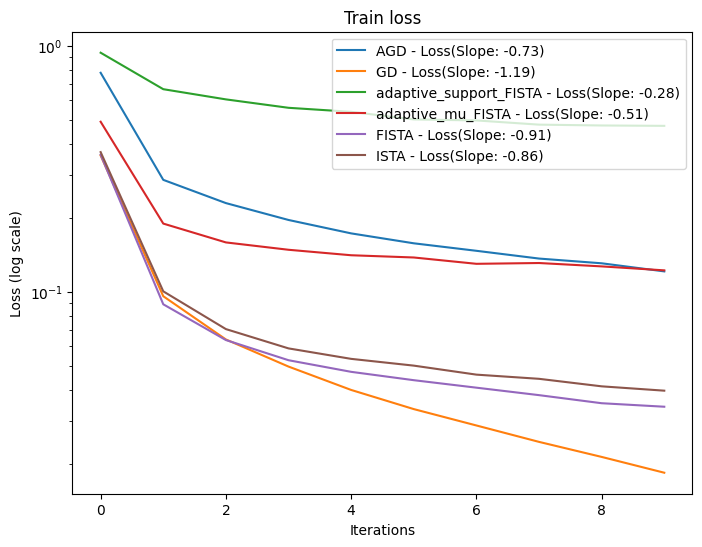

In [ ]:
# Plot results and stuff
fig, ax1 = plt.subplots(figsize=(8,6))

for name, (losses, stop_iter) in results.items():

    iterations = np.arange(1, len(losses) + 1)  # Iteration numbers

    log_iters = np.log(iterations)
    log_losses = np.log(losses)

    # Supposing rate of convergence should be O(1/t^r) --> slope of logfit should be -r
    # e.g. AGD should have emipirical slope close to -2
    slope, intercept, _, _, _ = linregress(log_iters, log_losses)

    ax1.plot(losses, label=f"{name} - Loss(Slope: {slope:.2f})")
    #ax1.scatter(stop_iter, losses[stop_iter-1], marker='o', s=100, label=f"{name} Stop")

ax1.set_yscale('log')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss (log scale)')
ax1.set_title('Train loss')
#ax1.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax1.legend()
plt.show()

In [ ]:
# Result in a table
SPARSITY_THRESHOLD = 1e-5
table_data = []
for name, (accuracy, sparsity) in test_accuracies.items():
    table_data.append([name, sparsity * 100, accuracy * 100])

df_results = pd.DataFrame(table_data, columns=["Algorithm", "Final Sparsity (%)", "Test Accuracy (%)"])
df_results.round(3)

,Algorithm,Final Sparsity (%),Test Accuracy (%)
0,AGD,0.069,96.89
1,GD,0.071,98.43
2,adaptive_support_FISTA,55.299,55.77
3,adaptive_mu_FISTA,18.644,97.48
4,FISTA,41.032,98.60
5,ISTA,42.644,98.04


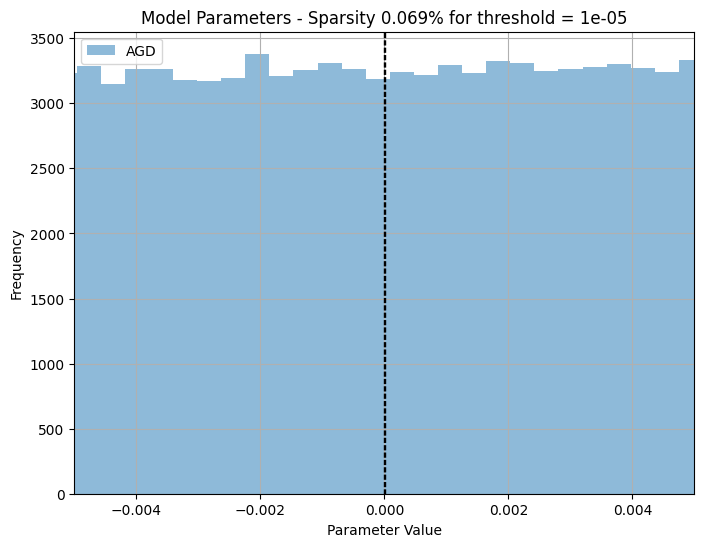

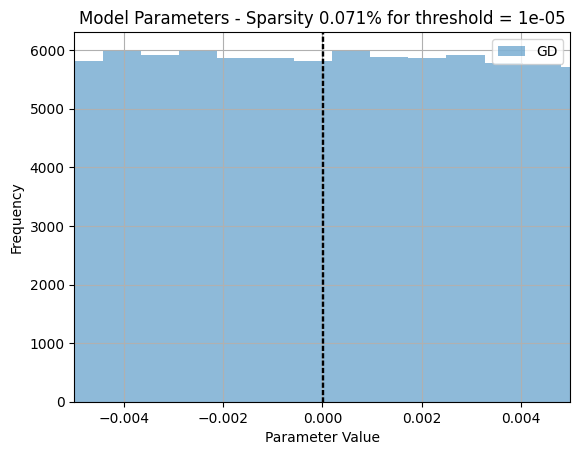

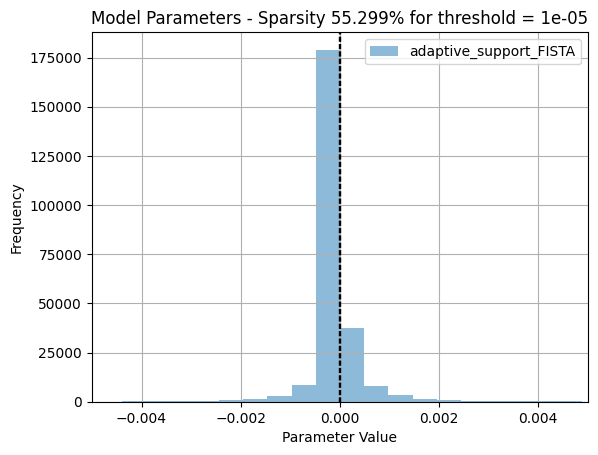

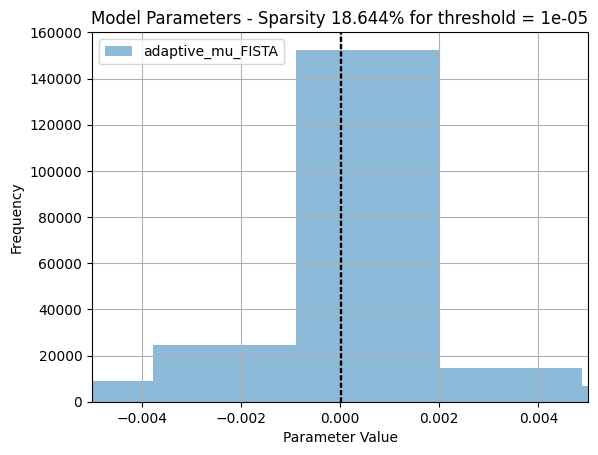

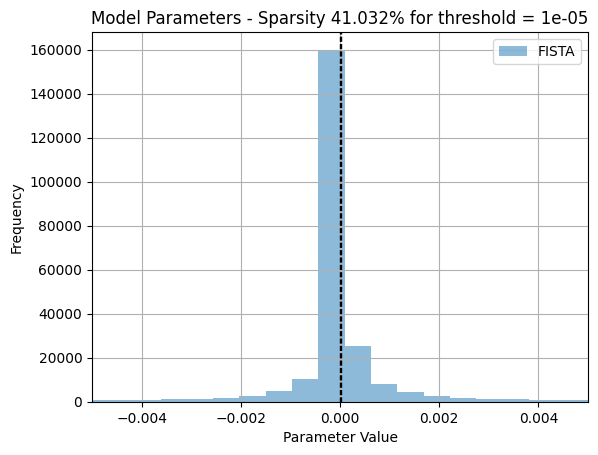

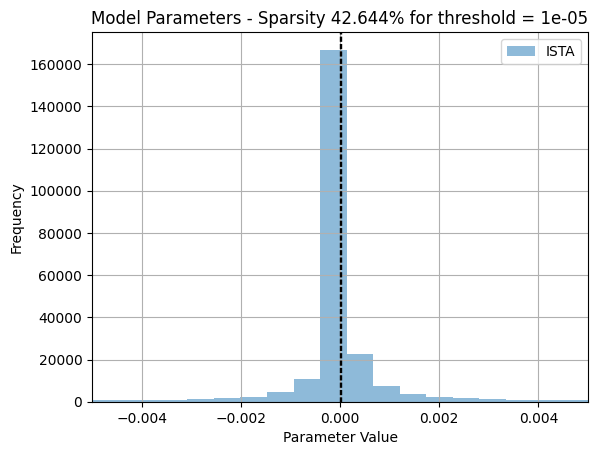

In [ ]:
def flatten_params(model):
    return torch.cat([param.view(-1).detach().cpu() for param in model.parameters() if param.dim() >= 2])

# Loop over models and plot histograms
plt.figure(figsize=(8, 6))

for method, model in models.items():
  params = flatten_params(model).numpy()
  plt.hist(params, bins=1000, alpha=0.5, label=method)
  a = 500
  plt.xlim(-a * SPARSITY_THRESHOLD, a * SPARSITY_THRESHOLD)
  plt.axvline(x=SPARSITY_THRESHOLD, color="black", linestyle="dashed", linewidth=1)
  plt.axvline(x=-SPARSITY_THRESHOLD, color="black", linestyle="dashed", linewidth=1)


  plt.xlabel("Parameter Value")
  plt.ylabel("Frequency")
  name = df_results['Final Sparsity (%)'][df_results['Algorithm'] == method].round(3).values[0]
  plt.title(f"Model Parameters - Sparsity {name}% for threshold = {SPARSITY_THRESHOLD}")
  plt.legend()
  plt.grid()
  plt.show()
